In [1]:
import numpy as np
import pandas as pd

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset

from sklearn.model_selection import train_test_split

# Define Network

In [2]:
class BiLSTM(nn.Module):

    def __init__(self, input_dim, hidden_dim, dense_dim, output_dim, num_layers, use_gpu, batch_size, is_training=True, dropout=0.5):
        """
        Args:
            ;input_dim: 30
            ;hidden_dim: 60
            ;dense_dim: 512
            ;output_dim: 4
            ;num_layers: 2 #stack two bilstm layers
        """
        super(BiLSTM, self).__init__()
        # inti self values
        self.use_gpu = use_gpu
        self.batch_size = batch_size
        self.dropout = dropout
        self.num_layers = num_layers
        self.is_training = is_training

        # define layers
        self.bilstm = nn.LSTM(input_size=input_dim, num_layers=num_layers, hidden_size=hidden_dim, bidirectional=True)
        self.dense_hidden = nn.Linear(hidden_dim*2, dense_dim)
        self.dense_out = nn.Linear(dense_dim, output_dim)

        # define hidden, cell for BiLSTM
        ## (num_layers * num_directions, batch, hidden_size)
        if use_gpu:
            self.h_0 = Variable(torch.zeros(2 * num_layers, self.batch_size, hidden_dim).cuda())
            self.c_0 = Variable(torch.zeros(2 * num_layers, self.batch_size, hidden_dim).cuda())
        else:
            self.h_0 = Variable(torch.zeros(2 * num_layers, self.batch_size, hidden_dim))
            self.c_0 = Variable(torch.zeros(2 * num_layers, self.batch_size, hidden_dim))

    def forward(self, audio_features):
        # audio_features = (seq_len, batch, input_size)
#         lstm_output, (h_1, c_1) = self.bilstm(audio_features, (self.h_0, self.c_0))
        lstm_output, (h_1, c_1) = self.bilstm(audio_features)
        
        #(seq_len, batch, input_size)  => (batch, input_size), only last output
        hidden_1 = self.dense_hidden(lstm_output[-1])  
        y = self.dense_out(hidden_1)

        # for cross entropy loss
        if self.is_training:
            return y
        else:
            return F.softmax(y)

In [3]:
# BiLSTM hyperparams
input_dim = 30
hidden_dim = 60
dense_dim = 512
output_dim = 4
num_layers = 2
use_gpu = True
is_cuda = True
is_training=True
batch_size = 32
dropout=0.2

In [4]:
bilstm = BiLSTM(
    input_dim,
    hidden_dim,
    dense_dim,
    output_dim,
    num_layers,
    use_gpu,
    batch_size,
    is_training,
    dropout
)

if is_cuda:
    bilstm.cuda()

In [5]:
# loss function
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(bilstm.parameters(), lr = 1e-3)

# read data

In [6]:
device = torch.device("cuda") 
data_dir = "../data/feature_array/"
features_dir = data_dir + "audio_features.npy"
labels_dir = data_dir + "labels.npy"

In [17]:
label_map_dict

{'ang': 0, 'exc': 1, 'neu': 2, 'sad': 3}

In [7]:
# load
labels = np.load(labels_dir)
features = np.load(features_dir)
# features = np.moveaxis(features, 0, -2).transpose()

# label string to onehot
label_map_dict = {lab:i for i, lab in enumerate(np.unique(labels))}
I_matrix = np.eye(len(label_map_dict))
labels_onehot = np.array([I_matrix[label_map_dict[lab]] for lab in labels])
labels_int = np.array([label_map_dict[lab] for lab in labels])

In [8]:
# train test split: 대략 10%
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels_int, test_size=0.1, random_state=42
)

In [9]:
class AudioDataset(Dataset):
    def __init__(self, train_features, train_labels): 
        self.len = len(train_labels)
        self.X = torch.from_numpy(train_features).float().to(device)
        self.y = torch.from_numpy(train_labels).long().to(device)
        
    def __getitem__(self, index): 
        return self.X[index], self.y[index] 
    
    def __len__(self): 
        return self.len

In [10]:
# generate batch
dataset = AudioDataset(train_features, train_labels)

train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# run training process
losses = []
for epoch in range(1000):
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, answers = data
        # (batch, input_size, seq_len) => (seq_len, batch, input_size)
        inputs_permute = inputs.permute(2,0,1) 
        
        outputs = bilstm(inputs_permute)
        
        loss = criterion(outputs, answers)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.data.item()
        
        losses.append(loss)
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

# predict

In [12]:
bilstm.is_training = False

In [13]:
# train predict
sample_train = torch.tensor(train_features).float().permute(2,0,1).to(device)
predict_train = bilstm(sample_train).argmax(dim=1).cpu().numpy()

print("train accuracy:", sum(predict_train == train_labels) / len(train_labels))

train accuracy: 0.9158036920306168


/home1/irteam/anaconda3/envs/py36_torch/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [14]:
# test predict
sample_test = torch.tensor(test_features).float().permute(2,0,1).to(device)
predict_test = bilstm(sample_test).argmax(dim=1).cpu().numpy()

print("test accuracy:", sum(predict_test == test_labels) / len(test_labels))

test accuracy: 0.4817813765182186


/home1/irteam/anaconda3/envs/py36_torch/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


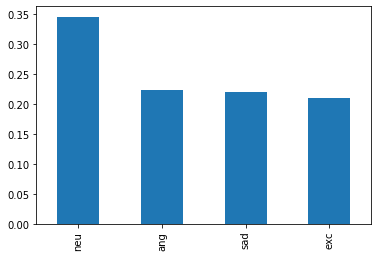

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

(pd.Series(labels).value_counts()/len(labels)).plot(kind="bar")

# save as state_dict
- https://tutorials.pytorch.kr/beginner/saving_loading_models.html#state-dict

In [16]:
torch.save(bilstm.state_dict(), "../data/bilstm_state_dict.pt")